# <a name="B1">Optimisation de la gestion des données de BottleNeck</a>

L'objectif de cette étude est d'améliorer la gestion des données de l'entreprise BottleNeck, c'est à dire avoir une vue centralisée de la vente: gestion de stock, évolution de la vente...</br>
Pour cela on va faire un rapprochement de l'ERP contenant les références produit, leur prix de vente et leur état de stock, et un export d’une table de l’outil de CMS contenant les informations des produits commercialisés en ligne (nom, description, nombre de ventes,..).</br>
À partir de cette jointure on va calculer le chiffre d'affaiire de BottleNeck et apporter une analyse sur le prix des produits.


## 1) Observation et nettoyage des fichiers

In [9]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

### 1-a) Fichier liaison

In [10]:
# Chargement du fichier liaison
liaison= pd.read_excel('liaison.xlsx')

In [11]:
# affichage des 5 premières lignes du dataframe liaison
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


Dans le fichier "liaison", on a deux variables: </br>
- product_id
- id_web

In [4]:
liaison.shape

(825, 2)

On peut voir qu'on a 825 lignes et 2 colonnes.

In [5]:
liaison.dtypes

product_id     int64
id_web        object
dtype: object

Dans cet dataframe, il n'y a pas de variables mal typé.

In [6]:
# recherche des valeurs manquantes
liaison.isnull().sum()

product_id     0
id_web        91
dtype: int64

Il y a  91 valeurs manquantes dans la varibale **id_web** et 0 dans celui de **product_id**.</br>
On ne va pas  encore supprimer ces valeurs manquantes car sinon on supprimera des références de produits et va fausser nos analyses.

Voyons si on a des doublons dans cet dataframe.

In [7]:
# Existence de doublon dans dataframe liaison
liaison.loc[liaison['product_id'].duplicated(keep=False),:]

,product_id,id_web


 Ici, on voit qu'il n'y a pas de doublon. </br>On peut prendre **product_id** comme clé primaire de la table liaison.

### 1-b) Fichier ERP

In [24]:
# chargement du fichier ERP
erp= pd.read_excel('erp.xlsx')

In [9]:
# Affichage des 5 premières lignes du dataframe
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [10]:
erp.shape

(825, 5)

Dans la table **erp**, on a 825 lignes et 5 colonnes. Les colonnes représentent les variables qui sont:</br>
- product_id
- onsale_web
- price
- stock_quantity
- stock-status

In [11]:
# type de chaque variable
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

Tous les 5 variables sont tous bien typés.

In [12]:
# Recherche des valeurs manquantes
erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

Le dataframe n'a pas de valeur manquante.

In [13]:
# Recherche de doublon
erp.loc[erp['product_id'].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status


On peut prendre **product_id** comme clé primaire de la table **erp** car dans cette variable on  n'a pas de doublon.

### 1-c) Fichier web

In [13]:
# chargement du fichier web
web= pd.read_excel('web.xlsx')

In [14]:
# Affiche les 5 premières lignes du dataframe
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [16]:
# Type des variables du dataframe
web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [15]:
web.shape

(1513, 28)

Ici on a 1513 lignes et 28 colonnes.


In [16]:
#Recherche des valeurs manquantes
web.isnull().sum()


sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

On voit qu'il y a 85 valeurs manquantes dans la variable **sku**. Comme c'est une clé candidate, voyons voir de près ces valeurs manquantes.

In [17]:
# 85 sku nul
recherche_null = web[web['sku'].isnull()]
print(recherche_null.shape)
print(' ')
recherche_null.head(30)

(85, 28)
 


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parmis ces valeurs manquantes, il y a 2 lignes qui correspondent à de vrais produits. On va les stocker dans le dataframe qu'on va appeler 'lignes'

In [20]:
lignes = recherche_null[recherche_null['post_type'].notnull()]
print(lignes.shape)
lignes
# ces 2 lignes correspondent a de vrais produits et sont stockees dans le dataframe 'lignes'

(2, 28)


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Une clé primaire ne doit pas avoir des valeurs nulles, on va stocker les variables de la dataframe **web** qui n'ont pas de valeurs manquantes dans un dataframe qu'on va appeler 'web_sans_null'.

In [18]:
web_sans_null = web[web['sku'].notnull()]

print(web_sans_null.shape)
print('')
web_sans_null.info()
web_sans_null.head()

(1428, 28)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1428 non-null   int64         
 2   downloadable           1428 non-null   int64         
 3   rating_count           1428 non-null   int64         
 4   average_rating         1428 non-null   float64       
 5   total_sales            1428 non-null   float64       
 6   tax_status             714 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1428 non-null   float64       
 9   post_date              1428 non-null   datetime64[ns]
 10  post_date_gmt          1428 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1428 non-null   object     

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [19]:
# Recherche des doublons
web1=web_sans_null[web_sans_null['sku'].duplicated()]
print(web1.shape)
print('')
web1.head()

(714, 28)



,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
799,15298,0,0,0,0.0,6.0,NaN,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
800,15296,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
801,15300,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
802,19814,0,0,0,0.0,3.0,NaN,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
803,19815,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-02-12 09:04:37,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


On voit qu'il y a 714 doublons dans la variable **sku** et qu'ils ne concernent que des image/jpeg et non des produits. On doit donc avoir 714 lignes et 28 colonnes après la suppression des doublons.</br>Supprimons les pour faire de la colonne **sku** la clé primaire de la table web.

In [21]:
# Suppression des doublons
web1.drop_duplicates(subset=['sku'],inplace=True)

In [22]:
# Dataframe nettoyé
web=web_sans_null
web.head()


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [69]:
web.shape

(714, 28)

Les doublons sont supprimés, il reste 714 lignes, on peut donc prendre la colonne **sku** comme clé primaire de la table web.</br>
Tous les 3 tables ont chacune  leur clé primaire, passons maintenat à la jointure de ces dataframes.

## 2) Jointures de l'ERP et du WEB

On va faire le rapprochement de l'erp et de la table web. La jointure va se faire en deux étapes. En premier lieu, on va faire la jointure de la table erp et celle de liaison car elles ont le variable **product_id** en commun. Puis dans un second lieu, le rapprochement de la nouvelle table avec la table web.</br> </br>
Ici on va choisir la jointure complète ou **full join** ou **full outer join** car on veut garder les données qui ont une correspondance à droite et à gauche de cette jointure.

In [25]:
# Jointure du dataframe erp et liaison
erp_liaison= pd.merge(erp,liaison,on= 'product_id',how='outer', indicator = True)

In [74]:
erp_liaison.head()

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge
0,3847,1,24.2,0,outofstock,15298,both
1,3849,1,34.3,0,outofstock,15296,both
2,3850,1,20.8,0,outofstock,15300,both
3,4032,1,14.1,0,outofstock,19814,both
4,4039,1,46.0,0,outofstock,19815,both


La dernière colonne **_merge** est créée grâce à l'argument dans la jointure **indicator= True**. Elle indique quelle ligne appartient à quel dataframe.

In [26]:
# Stockage des données appartenant à l'un ou l'autre dataframe
erp_liaison_test = erp_liaison[erp_liaison['_merge']!='both']
print(erp_liaison_test.shape)

(0, 7)


Toutes les lignes du dataframe résultant ont toutes trouvé correspondance.

In [27]:
# Jointure du dataframe erp_liaison et web
erp_liaison_web= pd.merge(erp_liaison,web, left_on ='id_web', right_on="sku", how='outer', indicator = 'exists')
print(erp_liaison_web.shape)
print('')
erp_liaison_web.head()


(825, 36)



,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,sku,virtual,downloadable,...,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,exists
0,3847,1,24.2,0,outofstock,15298,both,15298,0.0,0.0,...,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
1,3849,1,34.3,0,outofstock,15296,both,15296,0.0,0.0,...,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
2,3850,1,20.8,0,outofstock,15300,both,15300,0.0,0.0,...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
3,4032,1,14.1,0,outofstock,19814,both,19814,0.0,0.0,...,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both
4,4039,1,46.0,0,outofstock,19815,both,19815,0.0,0.0,...,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,both


In [84]:
erp_liaison_web_test = erp_liaison_web[erp_liaison_web['exists']!='both']
print(erp_liaison_web_test.shape)
erp_liaison_web_test.head()
# les "id_web" dans ce DF n'ont pas de correspondances. 

(111, 36)


,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge,sku,virtual,downloadable,...,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,exists
19,4055,0,86.1,0,outofstock,NaN,both,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
20,4090,0,73.0,0,outofstock,NaN,both,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
21,4092,0,47.0,0,outofstock,NaN,both,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22,4195,0,14.1,0,outofstock,NaN,both,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,4209,0,73.5,0,outofstock,NaN,both,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [28]:
# les 'id_web' dans ce DF ont trouvé une correspondance
df = erp_liaison_web[erp_liaison_web['exists'] =='both']
df.shape

(714, 36)

In [29]:
df = df.drop(['exists', '_merge'], axis = 1)
# enlevons les colonnes indicateurs car on n'en a plus besoin

Nous avons maintenant notre dataframe final.

In [30]:
df.shape 

(714, 34)

In [81]:
df.head()

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,sku,virtual,downloadable,rating_count,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,1,24.2,0,outofstock,15298,15298,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3849,1,34.3,0,outofstock,15296,15296,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,1,20.8,0,outofstock,15300,15300,0.0,0.0,0.0,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,4032,1,14.1,0,outofstock,19814,19814,0.0,0.0,0.0,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,4039,1,46.0,0,outofstock,19815,19815,0.0,0.0,0.0,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


## 3)  Calcul des chiffres d'affaires de chaque produit et le chiffre d'affaire total

In [85]:
# Chiffre d'affaire de chaque produit
df['ca']= df['price'] * df['total_sales']
print("Ci-joint les chiffres d'affaires de chaque produit:\n","\n",df.loc[:,['product_id','price','ca']],"\n")

print("Le chiffre d'affaire total de l'entreprise est :", "{:.2f}".format(df['ca'].sum()))

Ci-joint les chiffres d'affaires de chaque produit:
 
      product_id  price     ca
0          3847   24.2  145.2
1          3849   34.3    0.0
2          3850   20.8    0.0
3          4032   14.1   42.3
4          4039   46.0    0.0
..          ...    ...    ...
819        6930    8.4   42.0
820        7023   27.5    0.0
821        7025   69.0    0.0
822        7247   54.8    0.0
824        7338   16.3    0.0

[714 rows x 3 columns] 

Le chiffre d'affaire total de l'entreprise est : 70568.60


## 4) Analyse des prix des produits

Un describe va nous aider dans un premier temps à avoir la tendance centrale et la dipersion des prix :

In [86]:
df.price.describe()

count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

On voit que le prix minimum d'un produit est de 5.2 et le maximum est de 225. On va utiliser la méthode de l'écart interquartile pour détecter les outliers(valeurs extrêmes):</br>
Si certaines valeurs sont au-dessus de **Q<sub>3</sub> + 1.5(Q<sub>3</sub> - Q<sub>1</sub>)** alors on les considère comme des outliers.




In [87]:
seuil= 42.175 +1.5*(42.175-14.100)
print('La valeur du seuil est:',seuil,"\n")



La valeur du seuil est: 84.2875 



In [88]:
outlier=[]
price_list=df['price'].tolist()

for i  in price_list:
    if i>seuil:
        outlier.append(i)
print('Les outliers sont:', outlier,"\n")
print('Il y a ',len(outlier), "outliers.")
    

Les outliers sont: [100.0, 88.4, 225.0, 126.5, 85.6, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 86.8, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0] 

Il y a  32 outliers.


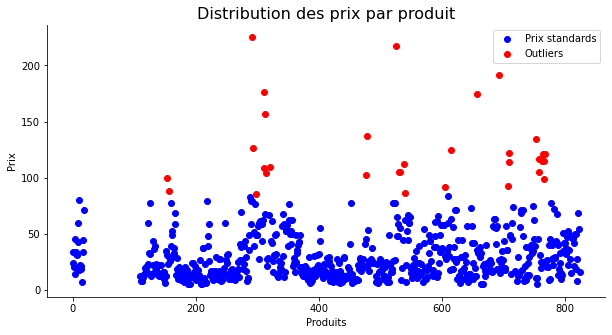

In [89]:
#Définition des quartiles et max
Q1 = 14.1
Q3 = 42.175
IQ = Q3 - Q1
Outliers = df[df['price']>Q3+1.5*IQ]
Prix_std = df[df['price']<=Q3+1.5*IQ]

#Définition du graphique
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(Prix_std['price'].index, Prix_std['price'].values, c='blue', label="Prix standards")
plt.scatter(Outliers['price'].index, Outliers['price'].values, c='red', label="Outliers")
plt.ylabel('Prix')
plt.xlabel('Produits')
ax.spines['top'].set_visible(False) ; ax.spines['right'].set_visible(False)
plt.legend()
pyplot.title("Distribution des prix par produit").set_fontsize(16)
